In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
from tqdm import tqdm_notebook
import datetime
import time
import random
from joblib import Parallel, delayed


import lightgbm as lgb
from tensorflow import keras
#from gplearn.genetic import SymbolicRegressor
from catboost import Pool, CatBoostRegressor

#import numpy as np 
#import pandas as pd
from tqdm import tqdm
# Define model
from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU, Dropout, TimeDistributed, LSTM, CuDNNLSTM
from keras.optimizers import adam, RMSprop
from keras.callbacks import ModelCheckpoint
# Fix seeds
from numpy.random import seed
#seed(639)
from tensorflow import set_random_seed
#set_random_seed(5944)

from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from itertools import product

from tsfresh.feature_extraction import feature_calculators
from joblib import Parallel, delayed

Using TensorFlow backend.


In [2]:
# Create a training file with simple derived features

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)

In [3]:
def get_extremal_accelerations(df, sort_field_name='acoustic_data', num_of_extremals=12):
    sorted_df = df.sort_values(sort_field_name)
    extremal_accelerations = []
    for i in range(num_of_extremals):
        idx_min = sorted_df.index[i]
        idx_max = sorted_df.index[-i - 1]
        min_v = df.iloc[idx_min][sort_field_name]
        max_v = df.iloc[idx_max][sort_field_name]
        extremal_accelerations.append((
            (max_v - min_v) / (idx_max - idx_min)
        ))
    return extremal_accelerations

In [4]:
def get_extremal_accelerations(series, num_of_extremals=12):
    sorted_series = series.sort_values()
    extremal_accelerations = []
    for i in range(num_of_extremals):
        idx_min = sorted_series.index[i]
        idx_max = sorted_series.index[-i - 1]
        min_v = series.iloc[idx_min]
        max_v = series.iloc[idx_max]
        extremal_accelerations.append((
            (max_v - min_v) / (idx_max - idx_min)
        ))
    return extremal_accelerations

In [5]:
class FeatureGenerator(object):
    def __init__(self, dtype, n_jobs=1, chunk_size=None):
        self.chunk_size = chunk_size
        self.dtype = dtype
        self.filename = None
        self.n_jobs = n_jobs
        self.test_files = []
        if self.dtype == 'train':
            self.filename = '../input/train/train.csv'
            self.total_data = int(629145481 / self.chunk_size)
            #print("Feature Generator __init__, self.total_data:", self.total_data)
        else:
            submission = pd.read_csv('../input/sample_submission.csv')
            for seg_id in submission.seg_id.values:
                self.test_files.append((seg_id, '../input/test/' + seg_id + '.csv'))
            #print("Feature Generator __init__, int(len(submission)):", int(len(submission)))
            self.total_data = int(len(submission))

    def read_chunks(self):
        if self.dtype == 'train':
            iter_df = pd.read_csv(self.filename, iterator=True, chunksize=self.chunk_size,
                                  dtype={'acoustic_data': np.float64, 'time_to_failure': np.float64})
            for counter, df in enumerate(iter_df):
                x = df.acoustic_data.values
                y = df.time_to_failure.values[-1]
                seg_id = 'train_' + str(counter)
                del df
                yield seg_id, x, y
        else:
            for seg_id, f in self.test_files:
                df = pd.read_csv(f, dtype={'acoustic_data': np.float64})
                x = df.acoustic_data.values[-self.chunk_size:]
                del df
                yield seg_id, x, -999
    
    def get_features(self, x, y, seg_id):
        """
        Gets three groups of features: from original data and from reald and imaginary parts of FFT.
        """
        
        x = pd.Series(x)
        
        '''
        zc = np.fft.fft(x)
        realFFT = pd.Series(np.real(zc))
        imagFFT = pd.Series(np.imag(zc))
        '''
        
        
        main_dict = self.features(x, y, seg_id)
        
        '''
        r_dict = self.features(realFFT, y, seg_id)
        i_dict = self.features(imagFFT, y, seg_id)
        
        for k, v in r_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'fftr_{k}'] = v
                
        for k, v in i_dict.items():
            if k not in ['target', 'seg_id']:
                main_dict[f'ffti_{k}'] = v
        '''
        return main_dict
        
    
    def features(self, x, y, seg_id):
        feature_dict = dict()
        feature_dict['target'] = y
        feature_dict['seg_id'] = seg_id

        # create features here

        # lists with parameters to iterate over them
        #percentiles = [1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99]
        percentiles = [10, 20]
        hann_windows = [50, 150, 1500, 15000]
        spans = [300, 3000, 30000, 50000]
        windows = [10, 50, 100, 500, 1000, 10000]
        borders = list(range(-4000, 4001, 1000))
        #peaks = [10, 20, 50, 100]
        peaks = [10]
        coefs = [1, 5, 10, 50, 100]
        lags = [10, 100, 1000, 10000]
        #autocorr_lags = [5, 10, 50, 100, 500, 1000, 5000, 10000]
        autocorr_lags = [5]
        # basic stats
        feature_dict['mean'] = x.mean()
        feature_dict['std'] = x.std()
        feature_dict['max'] = x.max()
        feature_dict['min'] = x.min()
        
        for i, e_acc in enumerate(get_extremal_accelerations(x, num_of_extremals=6)):
            feature_dict[f'e_acc_{i}'] = np.abs(e_acc)

        '''
        # basic stats on absolute values
        feature_dict['mean_change_abs'] = np.mean(np.diff(x))
        feature_dict['abs_max'] = np.abs(x).max()
        feature_dict['abs_mean'] = np.abs(x).mean()
        feature_dict['abs_std'] = np.abs(x).std()
        '''
        

        # geometric and harminic means
        '''
        feature_dict['hmean'] = stats.hmean(np.abs(x[np.nonzero(x)[0]]))
        feature_dict['gmean'] = stats.gmean(np.abs(x[np.nonzero(x)[0]])) 

        # k-statistic and moments
        for i in range(1, 5):
            feature_dict[f'kstat_{i}'] = stats.kstat(x, i)
            feature_dict[f'moment_{i}'] = stats.moment(x, i)

        for i in [1, 2]:
            feature_dict[f'kstatvar_{i}'] = stats.kstatvar(x, i)
        '''

        '''
        # aggregations on various slices of data
        for agg_type, slice_length, direction in product(['std', 'min', 'max', 'mean'], [1000, 10000, 50000], ['first', 'last']):
            if direction == 'first':
                feature_dict[f'{agg_type}_{direction}_{slice_length}'] = x[:slice_length].agg(agg_type)
            elif direction == 'last':
                feature_dict[f'{agg_type}_{direction}_{slice_length}'] = x[-slice_length:].agg(agg_type)
        '''
        

        '''
        feature_dict['max_to_min'] = x.max() / np.abs(x.min())
        feature_dict['max_to_min_diff'] = x.max() - np.abs(x.min())
        feature_dict['count_big'] = len(x[np.abs(x) > 500])
        feature_dict['sum'] = x.sum()

        feature_dict['mean_change_rate'] = calc_change_rate(x)
        # calc_change_rate on slices of data
        for slice_length, direction in product([1000, 10000, 50000], ['first', 'last']):
            if direction == 'first':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[:slice_length])
            elif direction == 'last':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[-slice_length:])
        '''
        
        '''
        # percentiles on original and absolute values
        for p in percentiles:
            feature_dict[f'percentile_{p}'] = np.percentile(x, p)
            feature_dict[f'abs_percentile_{p}'] = np.percentile(np.abs(x), p)
        '''
        
        '''
        feature_dict['trend'] = add_trend_feature(x)
        feature_dict['abs_trend'] = add_trend_feature(x, abs_values=True)
        '''

        feature_dict['mad'] = x.mad()
        feature_dict['kurt'] = x.kurtosis()
        feature_dict['skew'] = x.skew()
        feature_dict['med'] = x.median()

        '''
        feature_dict['Hilbert_mean'] = np.abs(hilbert(x)).mean()

        for hw in hann_windows:
            feature_dict[f'Hann_window_mean_{hw}'] = (convolve(x, hann(hw), mode='same') / sum(hann(hw))).mean()

        feature_dict['classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
        feature_dict['classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
        feature_dict['classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
        feature_dict['classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
        feature_dict['classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
        feature_dict['classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
        feature_dict['classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
        feature_dict['classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
        '''
        
        '''
        # exponential rolling statistics
        ewma = pd.Series.ewm
        for s in spans:
            feature_dict[f'exp_Moving_average_{s}_mean'] = (ewma(x, span=s).mean(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_average_{s}_std'] = (ewma(x, span=s).mean(skipna=True)).std(skipna=True)
            feature_dict[f'exp_Moving_std_{s}_mean'] = (ewma(x, span=s).std(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_std_{s}_std'] = (ewma(x, span=s).std(skipna=True)).std(skipna=True)

        feature_dict['iqr'] = np.subtract(*np.percentile(x, [75, 25]))
        feature_dict['iqr1'] = np.subtract(*np.percentile(x, [95, 5]))
        feature_dict['ave10'] = stats.trim_mean(x, 0.1)
        '''
        
        '''
        for slice_length, threshold in product([50000, 100000, 150000],
                                                     [5, 10, 20, 50, 100]):
            feature_dict[f'count_big_{slice_length}_threshold_{threshold}'] = (np.abs(x[-slice_length:]) > threshold).sum()
            feature_dict[f'count_big_{slice_length}_less_threshold_{threshold}'] = (np.abs(x[-slice_length:]) < threshold).sum()

        # tfresh features take too long to calculate, so I comment them for now

#         feature_dict['abs_energy'] = feature_calculators.abs_energy(x)
#         feature_dict['abs_sum_of_changes'] = feature_calculators.absolute_sum_of_changes(x)
#         feature_dict['count_above_mean'] = feature_calculators.count_above_mean(x)
#         feature_dict['count_below_mean'] = feature_calculators.count_below_mean(x)
#         feature_dict['mean_abs_change'] = feature_calculators.mean_abs_change(x)
#         feature_dict['mean_change'] = feature_calculators.mean_change(x)
#         feature_dict['var_larger_than_std_dev'] = feature_calculators.variance_larger_than_standard_deviation(x)
        feature_dict['range_minf_m4000'] = feature_calculators.range_count(x, -np.inf, -4000)
        feature_dict['range_p4000_pinf'] = feature_calculators.range_count(x, 4000, np.inf)
        '''
        
        '''
        for i, j in zip(borders, borders[1:]):
            feature_dict[f'range_{i}_{j}'] = feature_calculators.range_count(x, i, j)
        '''

#         feature_dict['ratio_unique_values'] = feature_calculators.ratio_value_number_to_time_series_length(x)
#         feature_dict['first_loc_min'] = feature_calculators.first_location_of_minimum(x)
#         feature_dict['first_loc_max'] = feature_calculators.first_location_of_maximum(x)
#         feature_dict['last_loc_min'] = feature_calculators.last_location_of_minimum(x)
#         feature_dict['last_loc_max'] = feature_calculators.last_location_of_maximum(x)

#         for lag in lags:
#             feature_dict[f'time_rev_asym_stat_{lag}'] = feature_calculators.time_reversal_asymmetry_statistic(x, lag)
        ## for autocorr_lag in autocorr_lags:
        ##    feature_dict[f'autocorrelation_{autocorr_lag}'] = feature_calculators.autocorrelation(x, autocorr_lag)
        ##    #feature_dict[f'c3_{autocorr_lag}'] = feature_calculators.c3(x, autocorr_lag)

#         for coeff, attr in product([1, 2, 3, 4, 5], ['real', 'imag', 'angle']):
#             feature_dict[f'fft_{coeff}_{attr}'] = list(feature_calculators.fft_coefficient(x, [{'coeff': coeff, 'attr': attr}]))[0][1]

#         feature_dict['long_strk_above_mean'] = feature_calculators.longest_strike_above_mean(x)
#         feature_dict['long_strk_below_mean'] = feature_calculators.longest_strike_below_mean(x)
#         feature_dict['cid_ce_0'] = feature_calculators.cid_ce(x, 0)
#         feature_dict['cid_ce_1'] = feature_calculators.cid_ce(x, 1)
        
    
        '''
        for p in percentiles:
            feature_dict[f'binned_entropy_{p}'] = feature_calculators.binned_entropy(x, p)

        feature_dict['num_crossing_0'] = feature_calculators.number_crossing_m(x, 0)
        '''
        
        ## for peak in peaks:
        ##    feature_dict[f'num_peaks_{peak}'] = feature_calculators.number_peaks(x, peak)
        
        '''
        for c in coefs:
            feature_dict[f'spkt_welch_density_{c}'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': c}]))[0][1]
            feature_dict[f'time_rev_asym_stat_{c}'] = feature_calculators.time_reversal_asymmetry_statistic(x, c)  
        '''
        
        # statistics on rolling windows of various sizes
        for w in windows:
            pass
            ## x_roll_std = x.rolling(w).std().dropna().values
            ## x_roll_mean = x.rolling(w).mean().dropna().values
            
            
            #feature_dict[f'ave_roll_std_{w}'] = x_roll_std.mean()
            #feature_dict[f'std_roll_std_{w}'] = x_roll_std.std()
            #feature_dict[f'max_roll_std_{w}'] = x_roll_std.max()
            
            ## feature_dict[f'min_roll_std_{w}'] = x_roll_std.min()
            

            ## for p in percentiles:
            ##    feature_dict[f'percentile_roll_std_{p}_window_{w}'] = np.percentile(x_roll_std, p)
            
            '''
            feature_dict[f'av_change_abs_roll_std_{w}'] = np.mean(np.diff(x_roll_std))
            feature_dict[f'av_change_rate_roll_std_{w}'] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
            feature_dict[f'abs_max_roll_std_{w}'] = np.abs(x_roll_std).max()

            feature_dict[f'ave_roll_mean_{w}'] = x_roll_mean.mean()
            feature_dict[f'std_roll_mean_{w}'] = x_roll_mean.std()
            feature_dict[f'max_roll_mean_{w}'] = x_roll_mean.max()
            feature_dict[f'min_roll_mean_{w}'] = x_roll_mean.min()
            
            for p in percentiles:
                feature_dict[f'percentile_roll_mean_{p}_window_{w}'] = np.percentile(x_roll_mean, p)

            feature_dict[f'av_change_abs_roll_mean_{w}'] = np.mean(np.diff(x_roll_mean))
            feature_dict[f'av_change_rate_roll_mean_{w}'] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
            feature_dict[f'abs_max_roll_mean_{w}'] = np.abs(x_roll_mean).max()    
            '''

        return feature_dict

    def generate(self):
        feature_list = []
        res = Parallel(n_jobs=self.n_jobs,
                       backend='threading')(delayed(self.get_features)(x, y, s)
                                            for s, x, y in tqdm_notebook(self.read_chunks(), total=self.total_data))
        #print("FeatureGenerator, generate, type(res)", type(res))
        #print("FeatureGenerator, generate, len(res)", len(res))
        for r in res:
            feature_list.append(r)
        #print("FeatureGenerator, generate, len(feature_list)", len(feature_list))
        return pd.DataFrame(feature_list)

train_X_0 = pd.read_csv("../input/lanl-masters-features-creating-0/train_X_features_865.csv")
train_X_1 = pd.read_csv("../input/lanl-masters-features-creating-1/train_X_features_865.csv")
y_0 = pd.read_csv("../input/lanl-masters-features-creating-0/train_y.csv", index_col=False,  header=None)
y_1 = pd.read_csv("../input/lanl-masters-features-creating-1/train_y.csv", index_col=False,  header=None)

train_X = pd.concat([train_X_0, train_X_1], axis=0)
train_X = train_X.reset_index(drop=True)
print(train_X.shape)
train_X.head()

y = pd.concat([y_0, y_1], axis=0)
y = y.reset_index(drop=True)
y[0].shape

train_y = pd.Series(y[0].values)

test_X = pd.read_csv("../input/lanl-masters-features-creating-0/test_X_features_10.csv")
'''
del X["seg_id"], test_X["seg_id"]
'''

In [6]:
training_fg = FeatureGenerator(dtype='train', n_jobs=20, chunk_size=30000)


training_data = training_fg.generate()

test_fg = FeatureGenerator(dtype='test', n_jobs=20, chunk_size=30000)
test_data = test_fg.generate()

X = training_data.drop(['target', 'seg_id'], axis=1)
X_test = test_data.drop(['target', 'seg_id'], axis=1)
test_segs = test_data.seg_id
y = training_data.target
train_y = y

In [7]:
print(X_test.shape, X.shape)

(2624, 14) (20972, 14)


In [8]:
X.head()

,e_acc_0,e_acc_1,e_acc_2,e_acc_3,e_acc_4,e_acc_5,kurt,mad,max,mean,med,min,skew,std
0,22.444444,17.909091,27.142857,20.444444,1.626168,1.105263,33.165839,4.066226,104.0,5.011700,5.0,-98.0,-0.129510,7.367779
1,9.375000,7.000000,0.005121,0.005974,0.005791,0.010464,4.354795,3.336135,40.0,4.846700,5.0,-35.0,0.070504,4.630081
2,12.000000,0.004695,0.004518,0.004289,0.003961,0.003915,15.249594,3.203834,52.0,5.132100,5.0,-56.0,0.024047,4.939919
3,7.200000,8.375000,2.600000,2.461538,2.259259,0.022822,6.538675,2.852130,40.0,4.922000,5.0,-32.0,0.018361,3.947113
4,0.297872,0.078212,0.002079,0.465909,0.573529,0.021752,2.022456,2.839988,26.0,4.508067,5.0,-16.0,0.047550,3.766104


In [9]:
means_dict = {}
for col in X.columns:
    if X[col].isnull().any():
        print(col)
        mean_value = X.loc[X[col] != -np.inf, col].mean()
        X.loc[X[col] == -np.inf, col] = mean_value
        X[col] = X[col].fillna(mean_value)
        means_dict[col] = mean_value

In [10]:
for col in X_test.columns:
    if X_test[col].isnull().any():
        X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
        X_test[col] = X_test[col].fillna(means_dict[col])

In [11]:
scaler = StandardScaler()
#train_columns = train_X.columns

#train_X[train_columns] = scaler.fit_transform(train_X[train_columns])
#test_X[train_columns] = scaler.transform(test_X[train_columns])

train_X = scaler.fit_transform(X)
test_X = scaler.transform(X_test)

In [12]:
# cols = train_X.columns

# df = pd.concat([train_X, test_X[cols]], axis=0)
# df = df.reset_index(drop=True)
# df[cols] = np.round(df.values, 3)

# for col in cols:
#     df[col+"_count"] = df[col].map(df[col].value_counts())
    
# count_cols = [i for i in df.columns if "_count" in i]

# train_X = pd.concat([train_X, df.loc[:40000-1, count_cols]], axis=1)
# test_X = pd.concat([test_X, df.loc[40000:, count_cols].reset_index(drop=True)], axis=1)
# train_X.shape, test_X.shape

# CatBoost

train_columns = train_X.columns
n_fold = 5

%%time
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

oof = np.zeros(len(train_X))
train_score = []
fold_idxs = []
'''
 if PREDICTION:
 '''
predictions = np.zeros(len(test_X))

feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    fold_idxs.append(val_idx)

    X_tr, X_val = train_X[train_columns].iloc[trn_idx], train_X[train_columns].iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = CatBoostRegressor(n_estimators=25000, verbose=-1, objective="MAE", loss_function="MAE", boosting_type="Ordered", task_type="GPU")
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_val, y_val)],
              '''
              eval_metric='mae',
              '''
              verbose=2500, 
              early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val)

    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    #if PREDICTION:

    predictions += model.predict(test_X[train_columns]) / folds.n_splits
    train_score.append(model.best_score_['learn']["MAE"])

cv_score = mean_absolute_error(train_y, oof)
print(f"After {n_fold} test_CV = {cv_score:.3f} | train_CV = {np.mean(train_score):.3f} | {cv_score-np.mean(train_score):.3f}", end=" ")

today = str(datetime.date.today())
submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv')

submission["time_to_failure"] = predictions
submission.to_csv(f'CatBoost_{today}_test_{cv_score:.3f}_train_{np.mean(train_score):.3f}.csv', index=False)
submission.head()

In [13]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [14]:
def train_model(X, X_test, y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if type(X) == np.ndarray:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [15]:
#prediction_xgb.shape

In [16]:
%%time
xgb_params = {'eta': 0.03, 'max_depth': 10, 'subsample': 0.85, #'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': True, 'nthread': 4}
oof_xgb, prediction_xgb, scores = train_model(X, X_test, y, params=xgb_params, model_type='xgb')

Fold 0 started at Wed May 29 17:15:46 2019
[0]	train-mae:5.07515	valid_data-mae:5.01269
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[86]	train-mae:1.66463	valid_data-mae:2.28381

Fold 1 started at Wed May 29 17:15:51 2019
[0]	train-mae:5.03663	valid_data-mae:5.17603
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[108]	train-mae:1.56181	valid_data-mae:2.3668

Fold 2 started at Wed May 29 17:15:57 2019
[0]	train-mae:5.08	valid_data-mae:5.00036
Multiple eval metrics have been passed: 'valid_data-mae' will be used for early stopping.

Will train until valid_data-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[95]	train-mae:1.61595	valid_data-mae:2.30769

Fold 3 started at Wed May 29 17:16:03 2019
[0]	train-mae:5

Fold 0 started at Wed May 29 17:16:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1152]	training's l1: 2.01083	valid_1's l1: 2.39433
Fold 1 started at Wed May 29 17:16:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1244]	training's l1: 1.97129	valid_1's l1: 2.48217
Fold 2 started at Wed May 29 17:16:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1307]	training's l1: 1.96809	valid_1's l1: 2.42841
Fold 3 started at Wed May 29 17:16:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1085]	training's l1: 2.01514	valid_1's l1: 2.46347
Fold 4 started at Wed May 29 17:16:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1308]	training's l1: 1.96703	valid_1's l1: 2.42143
CV mean score: 2.4380, std: 0.0312.

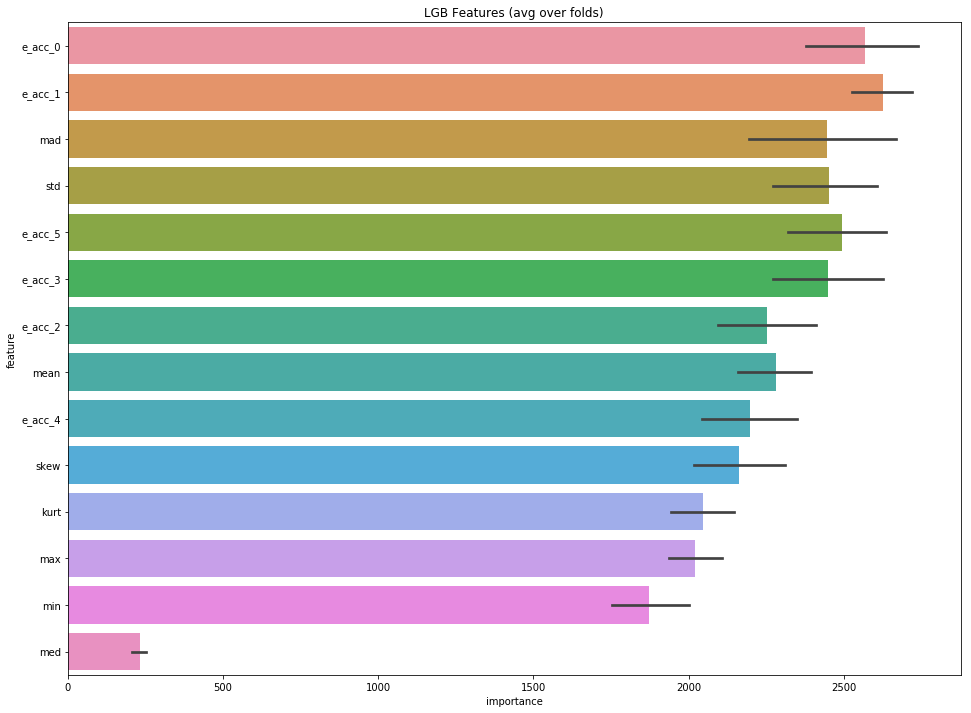

In [17]:
%%time
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'feature_fraction': 0.2
         }
oof_lgb, prediction_lgb, feature_importance = train_model(
    X,
    X_test,
    y,
    params=params,
    model_type='lgb',
    plot_feature_importance=True
)

# Neural Network

In [18]:
'''
def create_model(input_dim=10):

    model = keras.Sequential()
    model.add(keras.layers.Dense(256, activation="relu", input_dim=input_dim))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(96, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(1, activation="linear"))

    optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #'rmsprop'
    model.compile(optimizer=optimizer,loss='mae')
    return model
'''
patience = 50
call_ES = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=patience,
    verbose=1,
    mode='auto',
    baseline=None,
    #restore_best_weights=True
)

In [19]:
#%%time
cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=3)]
def create_model(input_dim=10):

    # The LSTM architecture
    model = Sequential()
    # First LSTM layer with Dropout regularisation
    model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=(None, input_dim)))
    model.add(Dropout(0.2))
    # Second LSTM layer
    model.add(CuDNNLSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    # Third LSTM layer
    model.add(CuDNNLSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    # Fourth LSTM layer
    model.add(CuDNNLSTM(units=50))
    model.add(Dropout(0.2))
    # The output layer
    model.add(Dense(units=1))

    # Compiling the RNN


    model.summary()
    model.compile(optimizer='rmsprop', loss='mae')
    return model

    # Compile and fit model
'''
model.compile(optimizer='rmsprop', loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=40,
                              verbose=2,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200
                             )
'''

"\nmodel.compile(optimizer='rmsprop', loss='mae')\n\nhistory = model.fit_generator(train_gen,\n                              steps_per_epoch=1000,\n                              epochs=40,\n                              verbose=2,\n                              callbacks=cb,\n                              validation_data=valid_gen,\n                              validation_steps=200\n                             )\n"

In [20]:
print(train_X.shape[-1])
print(train_X.shape)

14
(20972, 14)


In [21]:
train_X[:5]

array([[ 0.97631842,  0.64285657,  1.39860834,  1.08713946, -0.33612565,
        -0.35631039,  0.26153967,  0.2076963 ,  0.1436101 ,  1.73143967,
         0.95573555, -0.18776256, -0.57443946,  0.15701396],
       [ 0.02365161, -0.11287545, -0.55554979, -0.51437137, -0.47248075,
        -0.45877415, -0.78084979, -0.05113359, -0.32919506,  1.15104347,
         0.95573555,  0.290751  , -0.01152104, -0.14989879],
       [ 0.21499489, -0.59747823, -0.55559324, -0.51450339, -0.47263474,
        -0.459387  , -0.38667375, -0.09803637, -0.24054409,  2.15495302,
         0.95573555,  0.13124648, -0.14226936, -0.11516405],
       [-0.13488996, -0.01762173, -0.36869546, -0.32195906, -0.28285092,
        -0.45761748, -0.70183658, -0.22272156, -0.32919506,  1.41591519,
         0.95573555,  0.31353736, -0.15827081, -0.22646362],
       [-0.63800453, -0.5923853 , -0.55576888, -0.47833191, -0.42470541,
        -0.4577177 , -0.8652343 , -0.22702591, -0.43262118, -0.04011713,
         0.95573555,  0.43

In [22]:
%%time
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

NN_oof = np.zeros(len(train_X))
train_score = []
fold_idxs = []

NN_predictions = np.zeros(len(test_X))

num_of_features = train_X.shape[-1]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X, train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    fold_idxs.append(val_idx)
    
    ## X_tr, X_val = train_X[train_columns].iloc[trn_idx], train_X[train_columns].iloc[val_idx]
    X_tr, X_val = train_X[trn_idx], train_X[val_idx]
    X_tr = X_tr.reshape(len(X_tr), 1, num_of_features)
    X_val = X_val.reshape(len(X_val), 1, num_of_features)
    y_tr, y_val = train_y[trn_idx], train_y[val_idx]
    model = create_model(num_of_features)
    model.fit(X_tr, y_tr, epochs=50, batch_size=32, verbose=2, callbacks=[call_ES,], validation_data=[X_val, y_val]) #
    
    NN_oof[val_idx] = model.predict(X_val)[:,0]
    
    #NN_predictions += model.predict(test_X[train_columns])[:,0] / folds.n_splits
    test_X = test_X.reshape(len(test_X), 1, num_of_features)
    NN_predictions += model.predict(test_X)[:,0] / folds.n_splits
    history = model.history.history
    tr_loss = history["loss"]
    val_loss = history["val_loss"]
    print(f"loss: {tr_loss[-patience]:.3f} | val_loss: {val_loss[-patience]:.3f} | diff: {val_loss[-patience]-tr_loss[-patience]:.3f}")
    train_score.append(tr_loss[-patience])
#     break
    
cv_score = mean_absolute_error(train_y, NN_oof)
print(f"After {n_fold} test_CV = {cv_score:.3f} | train_CV = {np.mean(train_score):.3f} | {cv_score-np.mean(train_score):.3f}", end=" ")

fold 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, None, 50)          13200     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, None, 50)          20400     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, None, 50)          20400     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 50)                20400     
___

Epoch 48/50
 - 6s - loss: 2.2828 - val_loss: 2.3325
Epoch 49/50
 - 6s - loss: 2.2835 - val_loss: 2.3455
Epoch 50/50
 - 6s - loss: 2.2779 - val_loss: 2.3663
loss: 2.826 | val_loss: 2.573 | diff: -0.253
fold 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_9 (CuDNNLSTM)     (None, None, 50)          13200     
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, None, 50)          20400     
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_11 (CuDNNLSTM)    (None, None, 50)          20400     
_________________________________________________________________


Epoch 44/50
 - 6s - loss: 2.2824 - val_loss: 2.3323
Epoch 45/50
 - 6s - loss: 2.2928 - val_loss: 2.3329
Epoch 46/50
 - 6s - loss: 2.2768 - val_loss: 2.3253
Epoch 47/50
 - 6s - loss: 2.2752 - val_loss: 2.3508
Epoch 48/50
 - 6s - loss: 2.2788 - val_loss: 2.3309
Epoch 49/50
 - 6s - loss: 2.2838 - val_loss: 2.3295
Epoch 50/50
 - 6s - loss: 2.2762 - val_loss: 2.3261
loss: 2.835 | val_loss: 2.459 | diff: -0.376
fold 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_17 (CuDNNLSTM)    (None, None, 50)          13200     
_________________________________________________________________
dropout_17 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
cu_dnnlstm_18 (CuDNNLSTM)    (None, None, 50)          20400     
_________________________________________________________________
dropout_18 (Dropout)         (None, None, 50)          0

In [ ]:
#len(NN_predictions) * 2

In [ ]:
#type(NN_predictions[0])

In [ ]:
#today = str(datetime.date.today())
#submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv')

#submission["time_to_failure"] = NN_predictions
#submission.to_csv(f'NN_{today}_test_{cv_score:.3f}_train_{np.mean(train_score):.3f}.csv', index=False)
#submission.head()

# GPLearn

In [ ]:
# best_parameters = {'tournament_size': 17, 'population_size': 4000, 'p_crossover': 0.8, 'generations': 18}
# function_set = ('add', 'sub', 'mul', 'div', "sqrt", "log", "max", "min", "sin", "cos", "tan")

In [ ]:
# %%time
# # n_fold = 5
# folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

# GPL_oof = np.zeros(len(train_X))
# GPL_predictions = np.zeros(len(test_X))
# train_score = []

# for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X,train_y.values)):
#     strLog = "fold {}".format(fold_)
#     print(strLog)
    
#     X_tr, X_val = train_X[train_columns].iloc[trn_idx], train_X[train_columns].iloc[val_idx]
#     y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]
    
#     model = SymbolicRegressor(**best_parameters, stopping_criteria=0.0,const_range=(-1.0, 1.0), init_depth=(2, 6), init_method='half and half', 
#                           function_set=function_set, metric='mean absolute error', parsimony_coefficient=0.001,
#                           p_subtree_mutation=0.01, p_hoist_mutation=0.01, p_point_mutation=0.01, 
#                           p_point_replace=0.05, max_samples=1.0, feature_names=None, 
#                           warm_start=False, low_memory=False, n_jobs=-1, verbose=1, random_state=42)
    
#     model.fit(X_tr, y_tr) #
    
#     GPL_oof[val_idx] = model.predict(X_val)
#     GPL_predictions += model.predict(test_X[train_columns]) / folds.n_splits
    
#     train_score.append(model.run_details_["best_fitness"][-1])
# #     break
    
# cv_score = mean_absolute_error(train_y, GPL_oof)
# print(f"After {n_fold} test_CV = {cv_score:.3f} | train_CV = {np.mean(train_score):.3f} | {cv_score-np.mean(train_score):.3f}", end=" ")

In [ ]:
# today = str(datetime.date.today())
# submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv')

# submission["time_to_failure"] = GPL_predictions
# submission.to_csv(f'GPL_{today}_test_{cv_score:.3f}_train_{np.mean(train_score):.3f}.csv', index=False)
# submission.head()

# Final Submission

In [ ]:
#Scirpus_prediction = pd.read_csv("../input/andrews-new-script-plus-a-genetic-program-model/gpI.csv")
#Scirpus_prediction.head()

In [ ]:
#type(prediction_xgb)

In [ ]:
#type(prediction_lgb)

In [23]:
today = str(datetime.date.today())
submission = pd.read_csv('../input/sample_submission.csv')

submission["time_to_failure"] = (prediction_xgb + prediction_lgb + NN_predictions) / 3
submission.to_csv(f'xgb_lgb_nn_2_{today}_submission.csv', index=False)
submission.head()

,seg_id,time_to_failure
0,seg_00030f,2.449471
1,seg_0012b5,5.942364
2,seg_00184e,6.689695
3,seg_003339,8.646187
4,seg_0042cc,5.622608
